<a href="https://colab.research.google.com/github/lisatwyw/data-gym/blob/master/RespireNet_Littman3200.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Specify GPU usage

Runtime > Change type > GPU

# Mount drive for data storage

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

Mounted at /content/drive


Query for version number

In [ ]:
! python --version

# Download ICBHI data

In [ ]:
import os

if 0:
  ! mkdir '/content/drive/My Drive/Colab Notebooks/code/'
  os.chdir('/content/drive/My Drive/Colab Notebooks/code/')

  ! wget https://github.com/microsoft/RespireNet/archive/refs/heads/main.zip
  ! unzip main.zip 

  os.chdir('/content/drive/My Drive/Colab Notebooks/code/RespireNet-main/data/')
  ! wget -O icbhi.zip https://bhichallenge.med.auth.gr/sites/default/files/ICBHI_final_database/ICBHI_final_database.zip

  ! unzip icbhi.zip -d '/content/drive/My Drive/Colab Notebooks/code/RespireNet-main/data/'


os.chdir('/content/drive/My Drive/Colab Notebooks/code/RespireNet-main/')

#! wget https://bhichallenge.med.auth.gr/sites/default/files/ICBHI_final_database/ICBHI_Challenge_demographic_information.txt
#! wget https://bhichallenge.med.auth.gr/sites/default/files/ICBHI_final_database/events.zip 

#! unzip events.zip

In [ ]:
! ls 

CODE_OF_CONDUCT.md   images   __pycache__  SUPPORT.md
data		     LICENSE  README.md    trained_models
eval.py		     models   scripts	   train.py
image_dataloader.py  nets     SECURITY.md  utils.py


In [ ]:
import os
import itertools

import random
from tqdm import tqdm

import torch
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.optim import Adam, lr_scheduler

import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import torchvision
from torchvision.transforms import Compose, Normalize, ToTensor

# Confirm availability of GPU

In [ ]:
if 1:
  n=torch.cuda.device_count() 
  print('Has',n,'GPU(s)')
else:
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
  print('Found GPU at: {}'.format(device_name))

Has 1 GPU(s)


In [ ]:
# cannot install
# ! pip install pandas==0.22.0

# Install packages not yet available

In [ ]:
! pip install cmapy nlpaug==0.0.14

     |████████████████████████████████| 102kB 8.6MB/s 
  Created wheel for cmapy: filename=cmapy-0.6.6-cp37-none-any.whl size=3962 sha256=f8f6b771796e8af8032b71fa09bd8b913aea3ec9210eac20bd7943a8e0d086ea
  Stored in directory: /root/.cache/pip/wheels/6d/75/b1/b8645ff93df032bd16a383e7774e03d904476450d767fb1dcf
Successfully built cmapy


# Change directory (and ensure needed files are listed) 

In [ ]:
! ls -lstr '/content/drive/My Drive/Colab Notebooks/code/RespireNet-main/data'
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/code/RespireNet-main/')

! ls -lstr 

total 6
1 -rw------- 1 root root   20 Dec  8 02:31 Readme.txt
4 drwx------ 2 root root 4096 Mar 27 03:22 ICBHI_final_database
1 -rw------- 1 root root  139 Mar 27 06:55 patient_list_foldwise.txt
1 -rw------- 1 root root  756 Mar 27 06:57 patient_list_foldwise0.txt
0 -rw------- 1 root root    0 Mar 29 03:10 icbhi.zip
total 84
13 -rw------- 1 root root 12564 Dec  8 02:31 train.py
 2 -rw------- 1 root root  1315 Dec  8 02:31 SUPPORT.md
 3 -rw------- 1 root root  2780 Dec  8 02:31 SECURITY.md
 4 drwx------ 2 root root  4096 Dec  8 02:31 scripts
 6 -rw------- 1 root root  5479 Dec  8 02:31 README.md
 4 drwx------ 3 root root  4096 Dec  8 02:31 nets
 4 drwx------ 2 root root  4096 Dec  8 02:31 models
 2 -rw------- 1 root root  1141 Dec  8 02:31 LICENSE
 4 drwx------ 2 root root  4096 Dec  8 02:31 images
 6 -rw------- 1 root root  5810 Dec  8 02:31 eval.py
 4 drwx------ 3 root root  4096 Dec  8 02:31 data
 1 -rw------- 1 root root   444 Dec  8 02:31 CODE_OF_CONDUCT.md
 4 drwx------ 2 root roo

# Check file count of sample data in ICBHI folder

In [ ]:
#  mkdir data/ICBHI_final_database/subset
#  mv data/ICBHI_final_database/*4*wav mkdir data/ICBHI_final_database/subset/
# mv data/ICBHI_final_database/*4*txt mkdir data/ICBHI_final_database/subset/
# ls data/ICBHI_final_database/subset/*txt | wc -l

# mv  data/ICBHI_final_database/subset/*.*  data/ICBHI_final_database/

! ls data/ICBHI_final_database/*wav | wc -l

ls: cannot access 'data/ICBHI_final_database/*wav': No such file or directory
0


# [Optional] Execute below if you wish to update files under utils, image_dataloader


In [ ]:
# /content/drive/My Drive/Colab Notebooks/code/RespireNet-main

import utils
import autoreload  
%reload_ext autoreload

# "mark" this module to be reloaded
%aimport utils
%aimport image_dataloader 

# same as import myutils, but also import all "marked" modules such as myutils
%autoreload 2

# Change code so it uses default settings

- ```gpu_ids``` need to be adjusted!

In [ ]:
import argparse

from datetime import date
today = date.today()

# dd/mm/YY
now = today.strftime("%m-%d")
print("today", now)

parser = argparse.ArgumentParser(description='RespireNet: Lung Sound Classification')
parser.add_argument('--weight_decay', default=0.0005,help='weight decay value')

# make sure this is adjusted
#parser.add_argument('--gpu_ids', default=[0,1], help='a list of gpus')
parser.add_argument('--gpu_ids', default=[0], help='a list of gpus')

parser.add_argument('--mixup', default=True, type=int, help='mix-up')

parser.add_argument('--num_worker', default=2, type=int, help='numbers of worker')
parser.add_argument('--batch_size', default=64, type=int, help='bacth size')
parser.add_argument('--start_epochs', default=0, type=int, help='start epochs')

parser.add_argument('--data_dir', default='/content/drive/My Drive/Colab Notebooks/code/RespireNet-main/data/ICBHI_final_database', help='data directory')

if 0: # init test stage
  parser.add_argument('--aug_scale', default=2, type=int, help='Augmentation multiplier')
  parser.add_argument('--lr', default=1e-4, type=float, help='learning rate')
  parser.add_argument('--epochs', default=4, type=int, help='epochs')
  parser.add_argument('--folds_file', default='/content/drive/My Drive/Colab Notebooks/code/RespireNet-main/data/patient_list_foldwise.txt', help='folds text file')

else:
  parser.add_argument('--aug_scale', default=None, type=int, help='Augmentation multiplier')
  parser.add_argument('--lr', default=5e-4, type=float, help='learning rate')
  parser.add_argument('--epochs', default=100, type=int, help='epochs')
  parser.add_argument('--folds_file', default='/content/drive/My Drive/Colab Notebooks/code/RespireNet-main/data/patient_list_foldwise0.txt', help='folds text file')

parser.add_argument('--test_fold', default=4, type=int, help='Test Fold ID')
parser.add_argument('--stetho_id', default=3, type=int, help='Stethoscope device id')
 
parser.add_argument('--model_path', default='/content/drive/My Drive/Colab Notebooks/code/RespireNet-main/trained_models/', help='model saving directory')
#parser.add_argument('--checkpoint', default='/content/drive/My Drive/Colab Notebooks/code/RespireNet-main/trained_models/03-31_mix1_b24_ste-1.pkl', type=str, help='load checkpoint')

parser.add_argument('--checkpoint', default=None, type=str, help='load checkpoint')


args = parser.parse_args('')
print( args.data_dir, '\n', args.folds_file, '\n', args.checkpoint, '\nbatch_size=', args.batch_size )


today 04-01
/content/drive/My Drive/Colab Notebooks/code/RespireNet-main/data/ICBHI_final_database 
 /content/drive/My Drive/Colab Notebooks/code/RespireNet-main/data/patient_list_foldwise0.txt 
 None 
batch_size= 64


In [ ]:
! ls -lstr '/content/drive/My Drive/Colab Notebooks/code/RespireNet-main/trained_models/'

total 585287
83612 -rw------- 1 root root 85618685 Mar 27 15:39 ckpt_best_10_-1.pkl
83612 -rw------- 1 root root 85618685 Mar 27 18:56 ckpt_best_100_-1.pkl
83612 -rw------- 1 root root 85618685 Mar 28 22:21 03-28-ckpt_best_ep4_ste-1.pkl
83612 -rw------- 1 root root 85618685 Mar 29 21:19 03-28-ckpt_best_ep200_ste-1.pkl
83612 -rw------- 1 root root 85618685 Mar 30 01:17 03-28-ckpt_best_ep100_ste-1.pkl
    2 -rw------- 1 root root     1088 Mar 30 16:31 03-30_mix1_b32_ste-1_progress.mat
83613 -rw------- 1 root root 85618749 Mar 30 17:27 03-30_mix1_b32_ste-1.pkl
83613 -rw------- 1 root root 85618749 Mar 30 21:31 03-30_mix1_b64_ste-1.pkl


Train import done successfully
0.0  to init trainer
The model will be saved under /content/drive/My Drive/Colab Notebooks/code/RespireNet-main/trained_models/
DEVICE DICT {'AKGC417L': 0, 'LittC2SE': 1, 'Meditron': 2, 'Litt3200': 3, 'format': 4, 'script': 5, 'differences': 6}
Device 0 32
Device 1 23
Device 2 64
Device 3 11
Device 4 1
Device 5 1
Device 6 1
Getting filenames ...
Cannot include filename_format
Cannot include filename_differences


0it [00:00, ?it/s]

922 filenames
Exracting Individual Cycles


42it [00:06,  6.17it/s]

TRAIN DETAILS
CLASSWISE SAMPLE COUNTS: [205.  11. 108.  26.]
Device to ID {'AKGC417L': 0, 'LittC2SE': 1, 'Meditron': 2, 'Litt3200': 3, 'format': 4, 'script': 5, 'differences': 6}
DEVICE ID 0 size 0
DEVICE ID 1 size 0
DEVICE ID 2 size 0
DEVICE ID 3 size 350
DEVICE ID 4 size 0
DEVICE ID 5 size 0
DEVICE ID 6 size 0
CLASSWISE PROBS [0.58571429 0.03142857 0.30857143 0.07428571]
LEN AUDIO DATA 350
==> Computing mean and std..


MEAN tensor([0.4098, 0.1420, 0.3541]) STD tensor([0.3017, 0.1362, 0.1695])
DEVICE DICT {'AKGC417L': 0, 'LittC2SE': 1, 'Meditron': 2, 'Litt3200': 3, 'format': 4, 'script': 5, 'differences': 6}
Device 0 32
Device 1 23
Device 2 64
Device 3 11
Device 4 1
Device 5 1
Device 6 1
Getting filenames ...
Cannot include filename_format
Cannot include filename_differences


42it [00:00, 278.94it/s]

922 filenames
Exracting Individual Cycles
TRAIN DETAILS
CLASSWISE SAMPLE COUNTS: [205.  11. 108.  26.]
Device to ID {'AKGC417L': 0, 'LittC2SE': 1, 'Meditron': 2, 'Litt3200': 3, 'format': 4, 'script': 5, 'differences': 6}
DEVICE ID 0 size 0
DEVICE ID 1 size 0
DEVICE ID 2 size 0
DEVICE ID 3 size 350
DEVICE ID 4 size 0
DEVICE ID 5 size 0
DEVICE ID 6 size 0
CLASSWISE PROBS [0.58571429 0.03142857 0.30857143 0.07428571]
LEN AUDIO DATA 350


DEVICE DICT {'AKGC417L': 0, 'LittC2SE': 1, 'Meditron': 2, 'Litt3200': 3, 'format': 4, 'script': 5, 'differences': 6}
Device 0 32
Device 1 23
Device 2 64
Device 3 11
Device 4 1
Device 5 1
Device 6 1
Getting filenames ...
Cannot include filename_format
Cannot include filename_differences


0it [00:00, ?it/s]

922 filenames
Exracting Individual Cycles


18it [00:05,  3.22it/s]

TEST DETAILS
CLASSWISE SAMPLE COUNTS: [131.  18.   7.   1.]
Device to ID {'AKGC417L': 0, 'LittC2SE': 1, 'Meditron': 2, 'Litt3200': 3, 'format': 4, 'script': 5, 'differences': 6}
DEVICE ID 0 size 0
DEVICE ID 1 size 0
DEVICE ID 2 size 0
DEVICE ID 3 size 157
DEVICE ID 4 size 0
DEVICE ID 5 size 0
DEVICE ID 6 size 0
CLASSWISE PROBS [0.8343949  0.11464968 0.04458599 0.00636943]
LEN AUDIO DATA 157
Sampling weights determined by class weights derived from dataset, which are: tensor([ 1.7073,  1.7073,  1.7073,  3.2407,  3.2407,  3.2407,  1.7073, 31.8182,
        31.8182,  1.7073, 13.4615, 13.4615, 13.4615, 13.4615, 31.8182, 31.8182,
         1.7073, 13.4615, 13.4615, 13.4615, 13.4615,  1.7073,  1.7073,  1.7073,
         1.7073,  1.7073,  1.7073,  3.2407,  3.2407,  3.2407,  3.2407,  3.2407,
         3.2407,  3.2407,  3.2407,  3.2407,  3.2407,  1.7073,  1.7073,  1.7073,
         1.7073,  1.7073,  1.7073,  1.7073,  1.7073, 31.8182,  1.7073,  1.7073,
         1.7073,  1.7073,  1.7073,  1.7073,  1.7



---------------------------------------------
Epoch 0 iter 5/6 Train Total loss: 1.404659628868103
Train Accuracy: 0.26571428571428574
Classwise_Losses Normal: 1.2982286095619202, Crackle: 1.296823380390803, Wheeze: 1.5026571912530027, Both: 1.4634329477945964
*************Metrics******************
Se: 0.19999999977777777, Sp: 0.48749999939062505, Score: 0.3437499995842014
Normal: 0.48749999939062505, Crackle: 0.48888888834567906, Wheeze: 0.07407407398262461, Both: 0.04040404036322824


Results on test set:

*********
Epoch 0, Validation BCE loss: 1.312537670135498
	Val Accuracy: 0.7324840764331211
	Confusion Matrix:
 [[113  18   0   0]
 [ 16   2   0   0]
 [  6   1   0   0]
 [  1   0   0   0]]
	Accuracy Score: 0.732484076433121
	Classwise Scores [0.86259542 0.11111111 0.         0.        ]
Best ACC achieved just now! 0.732484076433121
Best test ACC till now: 0.732484076433121


---------------------------------------------
Epoch 1 iter 5/6 Train Total loss: 1.3945941925048828
Train 

No handles with labels found to put in legend.



*********
Epoch 99, Validation BCE loss: 1.7105355262756348
	Val Accuracy: 0.07006369426751592
	Confusion Matrix:
 [[  0  17 112   2]
 [  0   4  12   2]
 [  0   0   7   0]
 [  0   0   1   0]]
	Accuracy Score: 0.07006369426751592
	Classwise Scores [0.         0.22222222 1.         0.        ]
Best test ACC till now: 0.732484076433121
Took 10.0 minutes to complete training
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'classwise_train_losses', 'test_acc', 'test_classwise_sc', 'test_losses', 'train_losses', 'train_se_sp_sc']
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', 

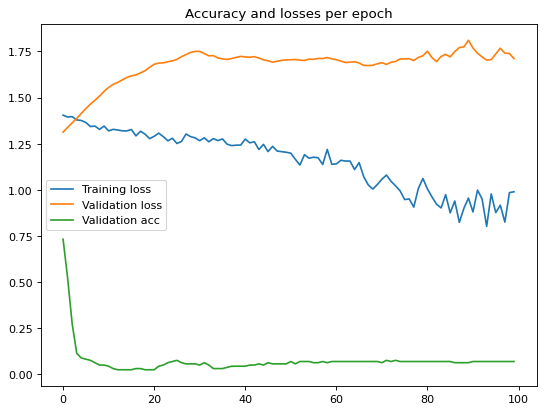

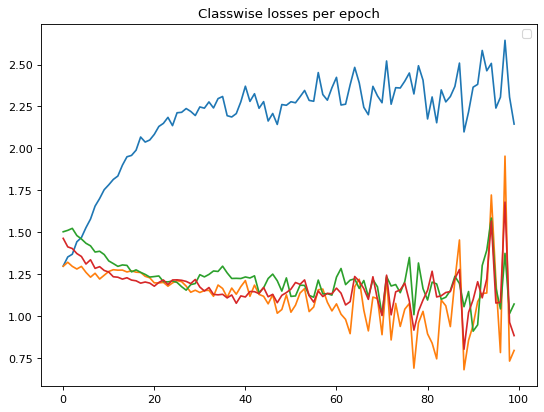

In [ ]:
# load external modules
from utils import *
from image_dataloader import *
from nets.network_cnn import *
#from nets.network_hybrid import *
from sklearn.metrics import confusion_matrix, accuracy_score
print("Train import done successfully")

################################MIXUP#####################################
def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

##############################################################################
def get_score(hits, counts, pflag=False):
    se = (hits[1] + hits[2] + hits[3]) / (counts[1] + counts[2] + counts[3])
    sp = hits[0] / counts[0]
    sc = (se+sp) / 2.0

    if pflag:
        print("*************Metrics******************")
        print("Se: {}, Sp: {}, Score: {}".format(se, sp, sc))
        print("Normal: {}, Crackle: {}, Wheeze: {}, Both: {}".format(hits[0]/counts[0], hits[1]/counts[1], 
            hits[2]/counts[2], hits[3]/counts[3]))
    return se,sp,sc
    
class progress:
    def __init__(self, ):        
        self.train_losses = []
        self.train_se_sp_sc = [] 
        self.classwise_train_losses = []

        self.test_losses = []
        self.test_acc = []        
        self.test_classwise_sc=[]
        
class Trainer:
    def __init__(self, nclasses=None, amodel=None ):
        self.args = args

        self.pref = args.model_path+'/%s_mix%d_b%d_ste%d'%(now, self.args.mixup, self.args.batch_size,self.args.stetho_id)
        self.progress=progress()
        if nclasses is None:
          self.nclasses = 4

        # loading checkpoint
        if amodel is None:
          self.net = model(num_classes=self.nclasses).cuda()

        if self.args.checkpoint is not None:
            checkpoint = torch.load(self.args.checkpoint)
            self.net.load_state_dict(checkpoint['model_state_dict'])
            # uncomment in case fine-tuning, specify block layer
            # before block_layer, all layers will be frozen durin training
            #self.net.fine_tune(block_layer=5)
            print("Pre-trained Model Loaded:", self.args.checkpoint)
        self.net = nn.DataParallel(self.net, device_ids=self.args.gpu_ids)

    def setup_training(self):
        # prepare dataset                
        mean, std = get_mean_and_std(image_loader(self.args.data_dir, self.args.folds_file, self.args.test_fold, True, "Params_json", Compose([ToTensor()]), stetho_id=self.args.stetho_id))        
        print("MEAN",  mean, "STD", std)

        self.input_transform = Compose([ToTensor(), Normalize(mean, std)])
        train_dataset = image_loader(self.args.data_dir, self.args.folds_file, self.args.test_fold, 
                True, "params_json", self.input_transform, stetho_id=self.args.stetho_id, aug_scale=self.args.aug_scale)
        test_dataset = image_loader(self.args.data_dir, self.args.folds_file, self.args.test_fold, 
                False, "params_json", self.input_transform, stetho_id=self.args.stetho_id)       

        self.test_ids = np.array(test_dataset.identifiers)
        self.test_paths = test_dataset.filenames_with_labels 
    
        # weighted sampler
        reciprocal_weights = []
        for idx in range(len(train_dataset)):
            reciprocal_weights.append(train_dataset.class_probs[train_dataset.labels[idx]])
        weights = (1 / torch.Tensor(reciprocal_weights))
        sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(train_dataset))

        print( 'Sampling weights determined by class weights derived from dataset, which are:', weights )  

        self.train_data_loader = DataLoader(train_dataset, num_workers=self.args.num_worker, 
                batch_size=self.args.batch_size, sampler=sampler)
        self.val_data_loader = DataLoader(test_dataset, num_workers=self.args.num_worker, 
                batch_size=self.args.batch_size, shuffle=False)

        #print("\n\nData loaded; shapes of train, val set are:", self.train_data_loader.shape, self.val_data_loader.shape )
        print("\n\nParams to learn:")
        params_to_update = []
        for name,param in self.net.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)

        # Observe that all parameters are being optimized
        self.optimizer = optim.SGD(params_to_update, lr=self.args.lr, momentum=0.9, weight_decay=self.args.weight_decay)
        #self.optimizer = optim.Adam(params_to_update, lr=self.args.lr, weight_decay=self.args.weight_decay)

        # Decay LR by a factor
        #self.exp_lr_scheduler = lr_scheduler.StepLR(self.optimizer, step_size=20, gamma=0.33)

        # weights for the loss function
        weights = torch.tensor([3.0, 1.0, 1.0, 1.0], dtype=torch.float32)
        #weights = torch.tensor(train_dataset.class_probs, dtype=torch.float32)
        weights = weights / weights.sum()
        weights = 1.0 / weights
        weights = weights / weights.sum()
        weights = weights.cuda()

        print('Class weights in loss function:', weights)
        self.loss_func = nn.CrossEntropyLoss(weight=weights)
        self.loss_nored = nn.CrossEntropyLoss(reduction='none')

    def evaluate(self, net, epoch, iteration):

        self.net.eval()
        test_losses = []
        class_hits = [0.0, 0.0, 0.0, 0.0] # normal, crackle, wheeze, both
        class_counts = [0.0, 0.0, 0.0+1e-7, 0.0+1e-7] # normal, crackle, wheeze, both
        running_corrects = 0.0
        denom = 0.0

        classwise_test_losses = [[], [], [], []]
        conf_label, conf_pred = [], []
        for i, (image, label) in enumerate(self.val_data_loader): #,ncols=100, desc='Train'):
            image, label = image.cuda(), label.cuda()
            output = self.net(image)
            
            # calculate loss from output
            loss = self.loss_func(output, label)
            loss_nored = self.loss_nored(output, label)
            test_losses.append(loss.data.cpu().numpy())
            
            _, preds = torch.max(output, 1)
            running_corrects += torch.sum(preds == label.data)

            # updating denom
            denom += len(label.data)

            #class
            for idx in range(preds.shape[0]):
                class_counts[label[idx].item()] += 1.0
                conf_label.append(label[idx].item())
                conf_pred.append(preds[idx].item())
                if preds[idx].item() == label[idx].item():
                    class_hits[label[idx].item()] += 1.0
                classwise_test_losses[label[idx].item()].append(loss_nored[idx].item())

        print('\n*********')
        print("Epoch {}, Validation BCE loss: {}".format(epoch, np.mean(test_losses)))
        print("\tVal Accuracy: {}".format(running_corrects.double() / denom))
        #print("Classwise_Losses Normal: {}, Crackle: {}, Wheeze: {}, Both: {}".format(np.mean(classwise_test_losses[0]),
        #    np.mean(classwise_test_losses[1]), np.mean(classwise_test_losses[2]), np.mean(classwise_test_losses[3])))
        #get_score(class_hits, class_counts, True)

        #aggregating same id, majority voting
        conf_label = np.array(conf_label)
        conf_pred = np.array(conf_pred)
        y_pred, y_true = [], []
        for pt in self.test_paths:
            y_pred.append(np.argmax(np.bincount(conf_pred[np.where(self.test_ids == pt)])))
            y_true.append(int(pt.split('_')[-1]))

        conf_matrix = confusion_matrix(y_true, y_pred)
        acc = accuracy_score(y_true, y_pred)
        print("\tConfusion Matrix:\n", conf_matrix)
        print("\tAccuracy Score:", acc)
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:,np.newaxis]
        print("\tClasswise Scores", conf_matrix.diagonal()) 
        self.net.train()

        return acc, np.mean(test_losses), conf_matrix.diagonal()

    def train(self):
        '''
        self.progress.classwise_train_losses = []
        self.progress.train_losses = []        
        self.progress.test_losses = []
        self.progress.test_acc = []
        ''';

        best_acc = -1
        for _, epoch in (enumerate(range(self.args.start_epochs, self.args.epochs))):
            losses = []
            class_hits = [0.0, 0.0, 0.0, 0.0]
            #nclasses = len(class_hits)
            class_counts = [0.0+1e-7, 0.0+1e-7, 0.0+1e-7, 0.0+1e-7]
            running_corrects = 0.0
            denom = 0.0
            classwise_train_losses = [[], [], [], []]
                
            for i, (image, label) in (enumerate(self.train_data_loader)):#, ncols=100, desc='Iterating imgs'):
                
                image, label = image.cuda(), label.cuda()
                # in case using mixup, uncomment 2 lines below
                if self.args.mixup:
                  image, label_a, label_b, lam = mixup_data(image, label, alpha=0.5)
                  image, label_a, label_b = map(Variable, (image, label_a, label_b))

                output = self.net(image)

                # calculate loss from output
                # in case using mixup, uncomment line below and comment the next line
                if self.args.mixup:
                  loss = mixup_criterion(self.loss_func, output, label_a, label_b, lam)
                else:
                  loss = self.loss_func(output, label)

                loss_nored = self.loss_nored(output, label)

                _, preds = torch.max(output, 1)
                running_corrects += torch.sum(preds == label.data)
                denom += len(label.data)

                #class
                for idx in range(preds.shape[0]):
                    class_counts[label[idx].item()] += 1.0
                    if preds[idx].item() == label[idx].item():
                         class_hits[label[idx].item()] += 1.0
                    classwise_train_losses[label[idx].item()].append(loss_nored[idx].item())

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                losses.append(loss.data.cpu().numpy())

                if i % 1000 == self.train_data_loader.__len__()-1:
                    print("\n\n---------------------------------------------")
                    print("Epoch {} iter {}/{} Train Total loss: {}".format(epoch,
                        i, len(self.train_data_loader), np.mean(losses)))
                    print("Train Accuracy: {}".format(running_corrects.double() / denom))

                    #for s in nclasses:
                    m1=np.mean(classwise_train_losses[0])
                    m2=np.mean(classwise_train_losses[1])
                    m3=np.mean(classwise_train_losses[2])
                    m4=np.mean(classwise_train_losses[3])

                    print("Classwise_Losses Normal: {}, Crackle: {}, Wheeze: {}, Both: {}".format(m1,m2,m3,m4))
                    se,sp,sc=get_score(class_hits, class_counts, True)

                    print("\n")
                    print("Results on test set:")
                    test_acc, test_loss, test_classwise_sc = self.evaluate(self.net, epoch, i)

                    if best_acc < test_acc:
                        best_acc = test_acc                        
                        torch.save( {'model_state_dict': self.net.module.state_dict(),'optimizer_state_dict': self.optimizer.state_dict()}, self.pref+'.pkl' )
                        print("Best ACC achieved just now!", best_acc.item())

                    print("Best test ACC till now:", best_acc)

                    self.progress.classwise_train_losses.append( (m1,m2,m3,m4) )
                    self.progress.train_se_sp_sc.append( (se,sp,sc) )
                    self.progress.train_losses.append(np.mean(losses))
                                       
                    self.progress.test_classwise_sc.append(test_classwise_sc)
                    self.progress.test_losses.append(test_loss)
                    self.progress.test_acc.append(test_acc)

            #self.exp_lr_scheduler.step()


#! mkdir trained_models

import time
if 1:  
  t1=time.process_time()
  rnet = Trainer(); 
  t2=time.process_time()
  print( (t2-t1 )//60, ' to init trainer' )
  print( 'The model will be saved under', rnet.args.model_path )

  t3=time.process_time()
  rnet.setup_training()
  t4=time.process_time()
  print( 'Took', (t4-t3 )//60, 'minutes to prepare trainer' )

  t5=time.process_time()
  rnet.train()
  t6=time.process_time()
  print( 'Took', (t6-t5 )//60, 'minutes to complete training' )

  print( dir( rnet.progress ) )

  import matplotlib.pyplot as plt
  %matplotlib inline 

  plt.figure(figsize=(8, 6), dpi=80) 
  plt.plot( rnet.progress.train_losses, label ='Training loss')
  plt.plot( rnet.progress.test_losses, label ='Validation loss')
  plt.plot( rnet.progress.test_acc, label ='Validation acc')
  plt.legend();
  plt.title( 'Accuracy and losses per epoch' );

  plt.figure(figsize=(8, 6), dpi=80)
  plt.plot( rnet.progress.classwise_train_losses ); 
  plt.legend()
  plt.title( 'Classwise losses per epoch' )

  p = rnet.progress 
  print( dir(p) )

  out='%s_progress.mat' % (rnet.pref)

  import scipy.io as spio
  spio.savemat( out, {'p': p } )


# Examine trained networks + restore network (weights), if available

In [ ]:
if 0:
  ! ls '/content/drive/My Drive/Colab Notebooks/code/RespireNet-main/trained_models/'

  try:
    checkpoint = torch.load( args.model_path + '/03-28-ckpt_best_ep200_ste-1.pkl' )
    #states=rnet.net.module.load_state_dict(checkpoint['model_state_dict'])
  except:
    print( 'No model checkpoints found in', args.model_path )

  for k in checkpoint.keys():
    print(k)

In [ ]:
! pwd

In [ ]:
# debugging
import image_dataloader
filenames, rec_annotations_dict = image_dataloader.get_annotations( args.data_dir )  
for i,k in enumerate(rec_annotations_dict.keys()):
  if i==0:
    print(k, rec_annotations_dict[k])


In [ ]:
for i,k in enumerate(rec_annotations_dict.keys()):
  if i==10:
    print(k, rec_annotations_dict[k])